In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import FeatureSpace
from tensorflow.keras import layers, regularizers
import keras_tuner as kt

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

2024-07-01 17:52:26.574960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 17:52:26.574991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 17:52:26.575901: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 17:52:26.580588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 17:52:27.178683: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("train.csv", index_col="Id")
df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1056,20,RL,104.0,11361,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,5,1976,1976,Gable,CompShg,Plywood,Plywood,BrkFace,160.0,TA,TA,CBlock,Gd,TA,No,ALQ,644,Unf,0,549,1193,GasA,TA,Y,SBrkr,1523,0,0,1523,0,1,2,0,3,1,TA,7,Typ,1,TA,Attchd,1976.0,Fin,2,478,TA,TA,Y,0,0,0,0,189,0,NaN,MnPrv,NaN,0,5,2008,COD,Abnorml,180000
901,20,RL,NaN,7340,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1971,1971,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,322,Unf,0,536,858,GasA,TA,Y,SBrkr,858,0,0,858,0,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1979.0,Unf,1,684,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,110000
1159,20,RL,92.0,11932,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Somerst,Feedr,Norm,1Fam,1Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1580,1580,GasA,Ex,Y,SBrkr,1580,0,0,1580,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2008.0,RFn,3,830,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,6,2008,ConLD,Partial,235128
95,60,RL,69.0,9337,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,Gd,PConc,Gd,TA,No,GLQ,648,Unf,0,176,824,GasA,Ex,Y,SBrkr,905,881,0,1786,1,0,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,1997.0,RFn,2,684,TA,TA,Y,0,162,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,204750
483,70,RM,50.0,2500,Pave,Pave,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,7,8,1915,2005,Gable,CompShg,Stucco,Stucco,NaN,0.0,Gd,TA,PConc,TA,TA,No,ALQ,299,Unf,0,611,910,GasA,Ex,Y,SBrkr,916,910,0,1826,1,0,1,1,4,1,Ex,7,Min2,1,Gd,Attchd,1915.0,Unf,1,164,Fa,Fa,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,155000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [4]:
# Missing values
missing_series = df.isna().sum().sort_values(ascending=False)
missing_series[missing_series > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [5]:
missing_df = pd.DataFrame(data=missing_series[missing_series > 0], columns=["num_missing"])
missing_df["dtype"] = "None"
missing_df["n_unique"] = 0
for col in missing_df.index:
    dtype = str(df[col].dtypes)
    if dtype == "0":
        missing_df.loc[col, "dtype"] = "object"
    else:
        missing_df.loc[col, "dtype"] = dtype
    missing_df.loc[col, "n_unique"] = len(df[col].unique())

In [6]:
missing_df

,num_missing,dtype,n_unique
PoolQC,1453,object,4
MiscFeature,1406,object,5
Alley,1369,object,3
Fence,1179,object,5
MasVnrType,872,object,4
FireplaceQu,690,object,6
LotFrontage,259,float64,111
GarageYrBlt,81,float64,98
GarageCond,81,object,6
GarageType,81,object,7


In [7]:
fill_with_none = ["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType", "FireplaceQu", "GarageCond", 
                  "GarageType", "GarageFinish", "GarageQual", "BsmtExposure", "BsmtFinType2", "BsmtCond", 
                  "BsmtQual", "BsmtFinType1"]
fill_with_0 = ["LotFrontage"]
to_impute_num = ["GarageYrBlt", "MasVnrArea"]
to_impute_object = ["Electrical"]
pass_through = [col for col in df.columns if col not in missing_df.index]

In [8]:
df_none = df[fill_with_none].fillna("none")
df_0 = df[fill_with_0].fillna(0)
df_num_0 = df[to_impute_num[0]].fillna(df[to_impute_num[0]].median())
df_num_1 = df[to_impute_num[1]].fillna(df[to_impute_num[1]].median())
df_objt = df[to_impute_object].fillna(df[to_impute_object].value_counts().index[0][0])

df = pd.concat([df_none, df_0, df_num_0, df_num_1, df_objt, df[pass_through]], axis=1)
df.sample(5)

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,GarageCond,GarageType,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,BsmtCond,BsmtQual,BsmtFinType1,LotFrontage,GarageYrBlt,MasVnrArea,Electrical,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,none,none,none,none,none,Gd,TA,Detchd,Unf,TA,No,Unf,Gd,TA,ALQ,60.0,1998.0,0.0,SBrkr,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
259,none,none,none,none,BrkFace,TA,TA,Attchd,RFn,TA,No,Unf,TA,Gd,GLQ,80.0,2001.0,172.0,SBrkr,60,RL,12435,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2001,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,361,0,602,963,GasA,Ex,Y,963,829,0,1792,0,0,2,1,3,1,Gd,7,Typ,1,2,564,Y,0,96,0,245,0,0,0,5,2008,WD,Normal,231500
683,none,none,none,none,none,Gd,TA,Attchd,Unf,TA,Mn,Unf,TA,Gd,GLQ,0.0,1996.0,0.0,SBrkr,120,RL,2887,Pave,Reg,HLS,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1Story,6,5,1996,1997,Gable,CompShg,Wd Sdng,Wd Sdng,TA,TA,PConc,1003,0,288,1291,GasA,Ex,Y,1291,0,0,1291,1,0,1,0,2,1,Gd,6,Typ,1,2,431,Y,307,0,0,0,0,0,0,11,2008,WD,Normal,173000
1164,none,none,none,none,none,none,TA,CarPort,Unf,Fa,Av,Unf,TA,Gd,GLQ,60.0,1969.0,0.0,SBrkr,90,RL,12900,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,Duplex,SFoyer,4,4,1969,1969,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,1198,0,0,1198,GasA,TA,Y,1258,0,0,1258,2,0,0,2,0,2,TA,6,Typ,0,2,400,Y,120,0,0,0,0,0,0,1,2008,WD,Alloca,108959
558,none,none,none,none,none,none,TA,CarPort,Unf,TA,No,Unf,TA,TA,Rec,60.0,1994.0,0.0,SBrkr,50,C (all),11040,Pave,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1.5Fin,4,6,1920,1950,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,637,0,0,637,GasA,Gd,Y,897,439,0,1336,0,0,1,1,3,1,TA,7,Typ,0,1,570,Y,0,47,120,0,0,0,0,9,2006,COD,Normal,108000


In [9]:
df.isna().sum().sum()

0

In [10]:
dtypes_df = pd.DataFrame(data={"n_unique": df.nunique().values, "dtype": [str(dtype) for dtype in df.dtypes.values]}, index=df.columns)
dtypes_df.sort_values(by="n_unique", ascending=False).to_csv("dtypes_df.csv")

In [11]:
large_num_cols = list(dtypes_df.loc[(dtypes_df["n_unique"] >= 25) & dtypes_df["dtype"].isin(["float64", "int64"])].index)
small_num_cols = list(dtypes_df.loc[(dtypes_df["n_unique"] < 25) & dtypes_df["dtype"].isin(["float64", "int64"])].index)
large_cat_cols = list(dtypes_df.loc[(dtypes_df["n_unique"] >= 10) & (dtypes_df["dtype"] == "object")].index)
small_cat_cols = list(dtypes_df.loc[(dtypes_df["n_unique"] < 10) & (dtypes_df["dtype"] == "object")].index)

print(f" large_num_cols: {len(large_num_cols)} \n small_num_cols: {len(small_num_cols)}")
print(f" large_cat_cols: {len(large_cat_cols)} \n small_cat_cols: {len(small_cat_cols)}")

 large_num_cols: 19 
 small_num_cols: 18
 large_cat_cols: 3 
 small_cat_cols: 40


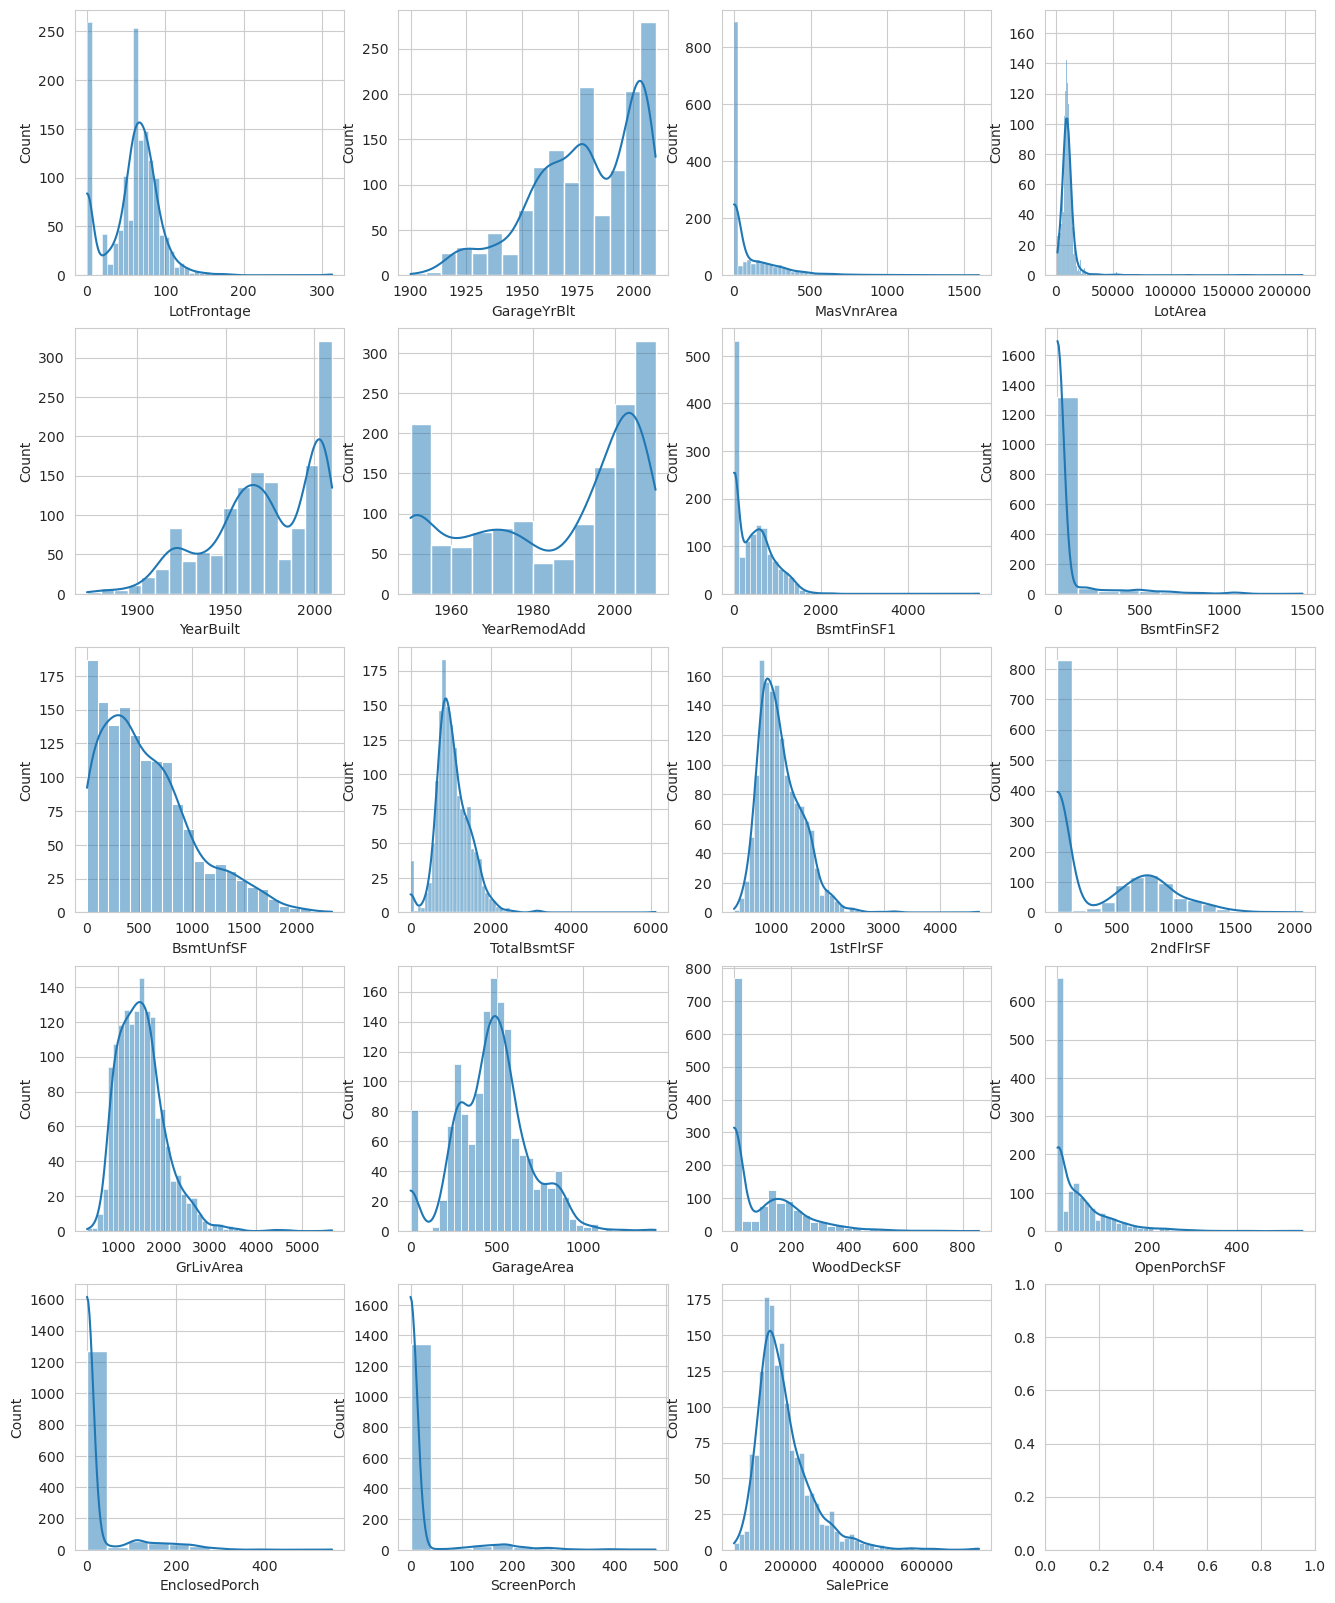

In [12]:
fig, axs = plt.subplots(ncols=4, nrows=int(np.ceil(len(large_num_cols) / 4)), figsize=(16, 20))
axs = axs.flat
for i, col in enumerate(large_num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
plt.show()

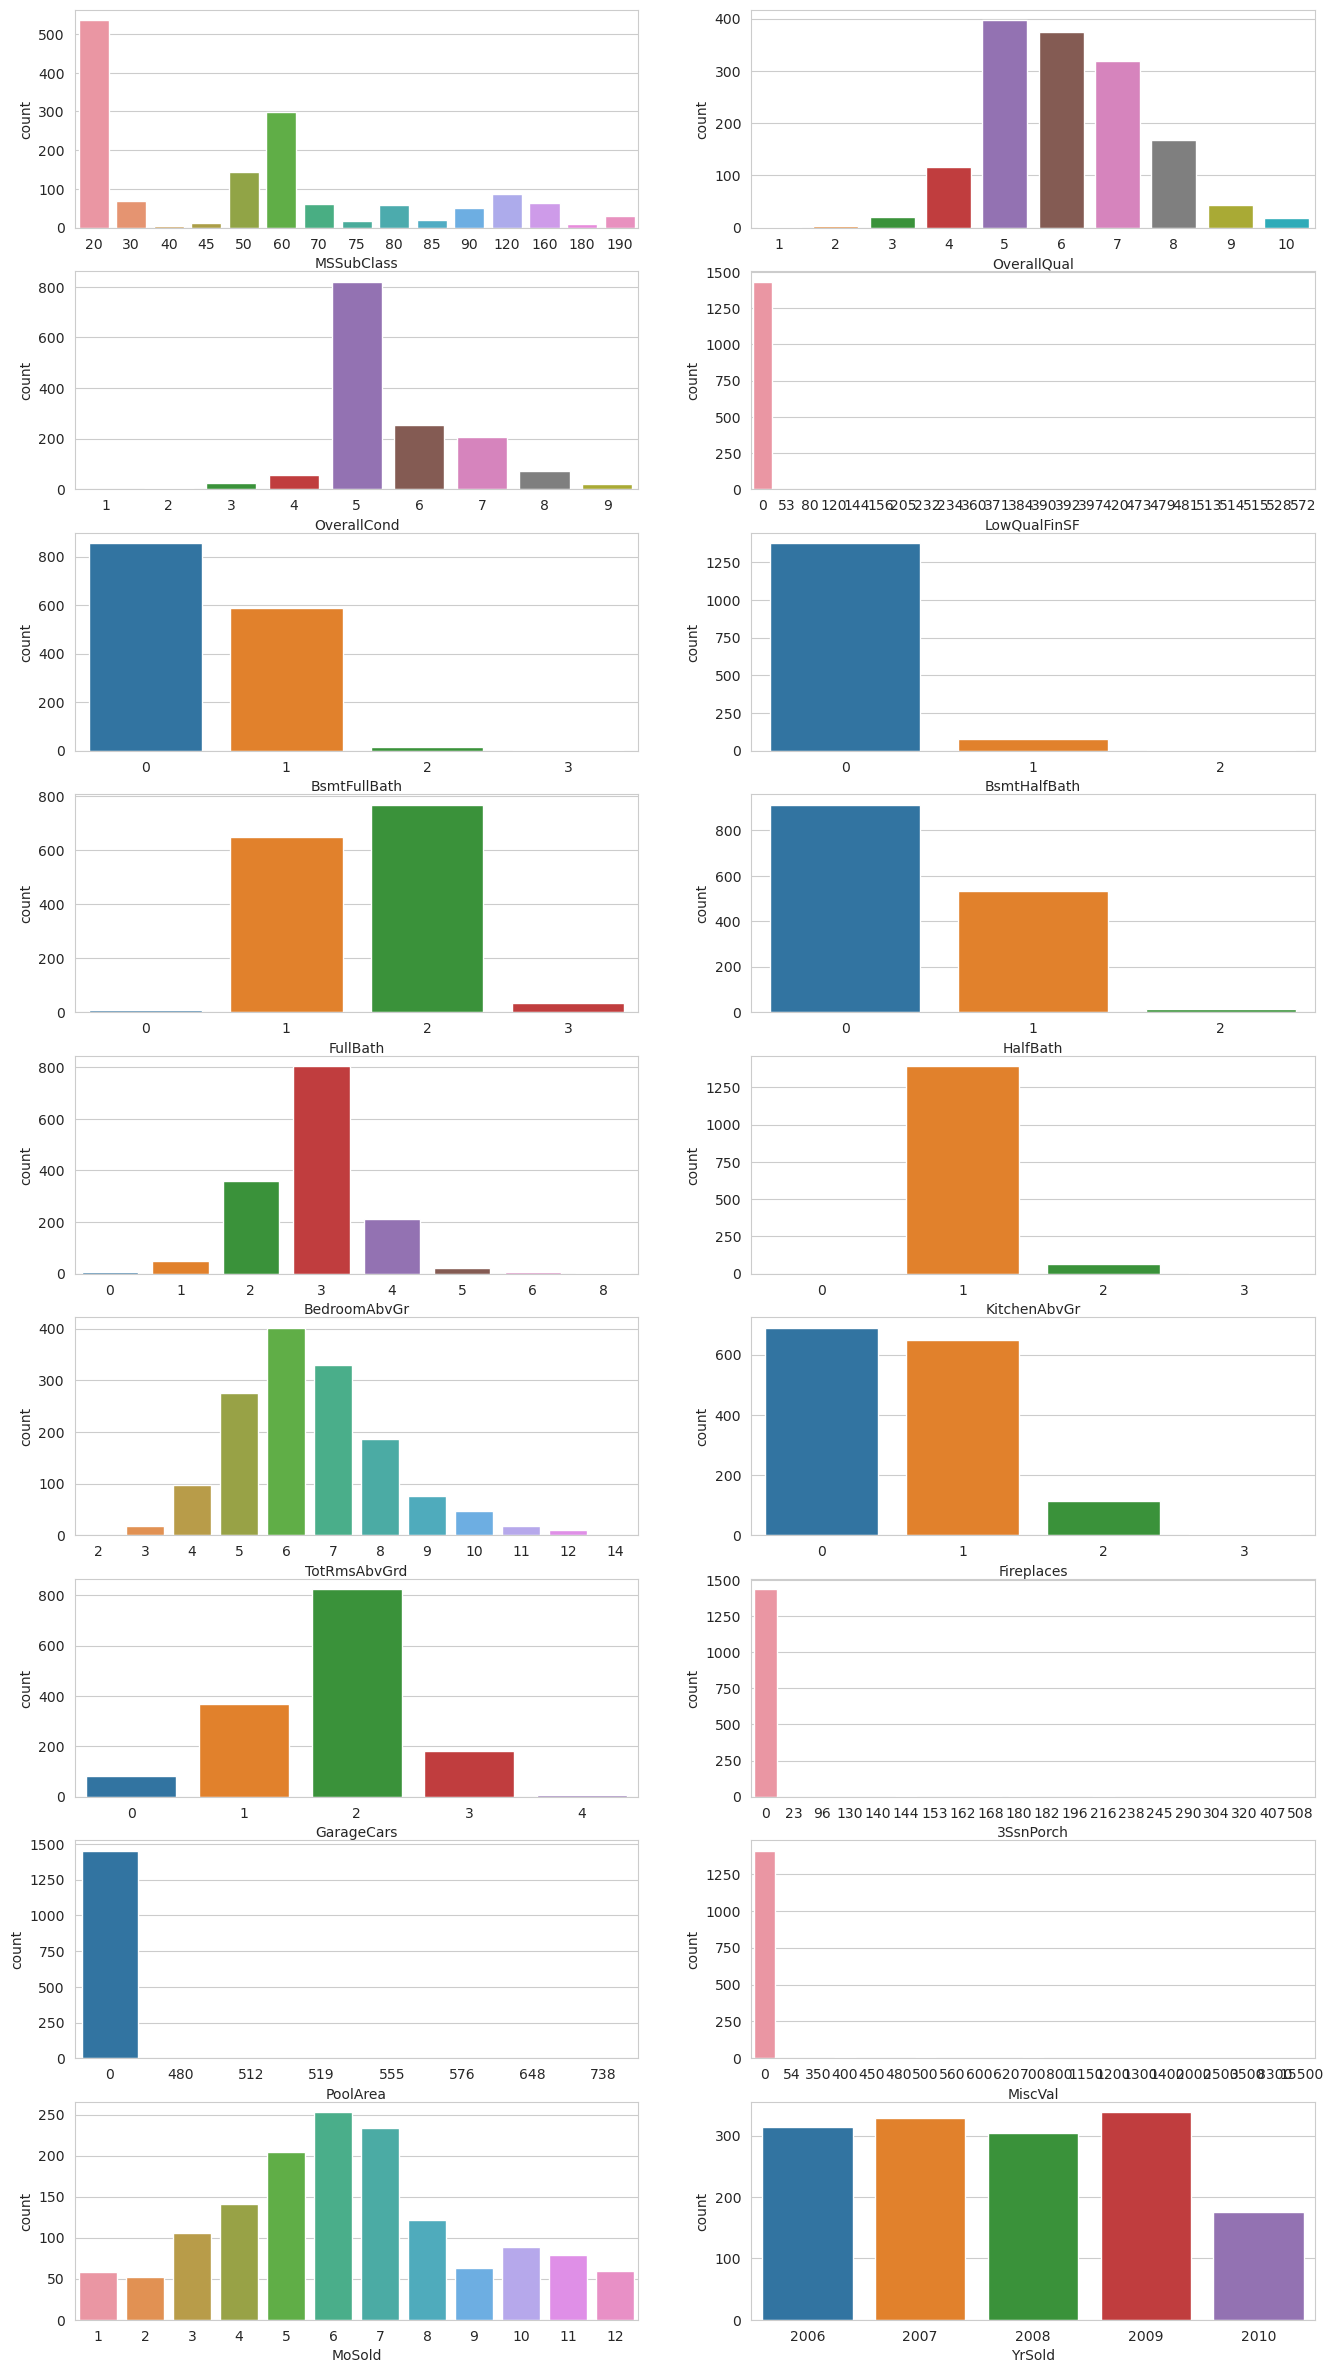

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=int(np.ceil(len(small_num_cols) / 2)), figsize=(16, 30))
axs = axs.flat
for i, col in enumerate(small_num_cols):
    sns.countplot(data=df, x=col, ax=axs[i])
plt.show()

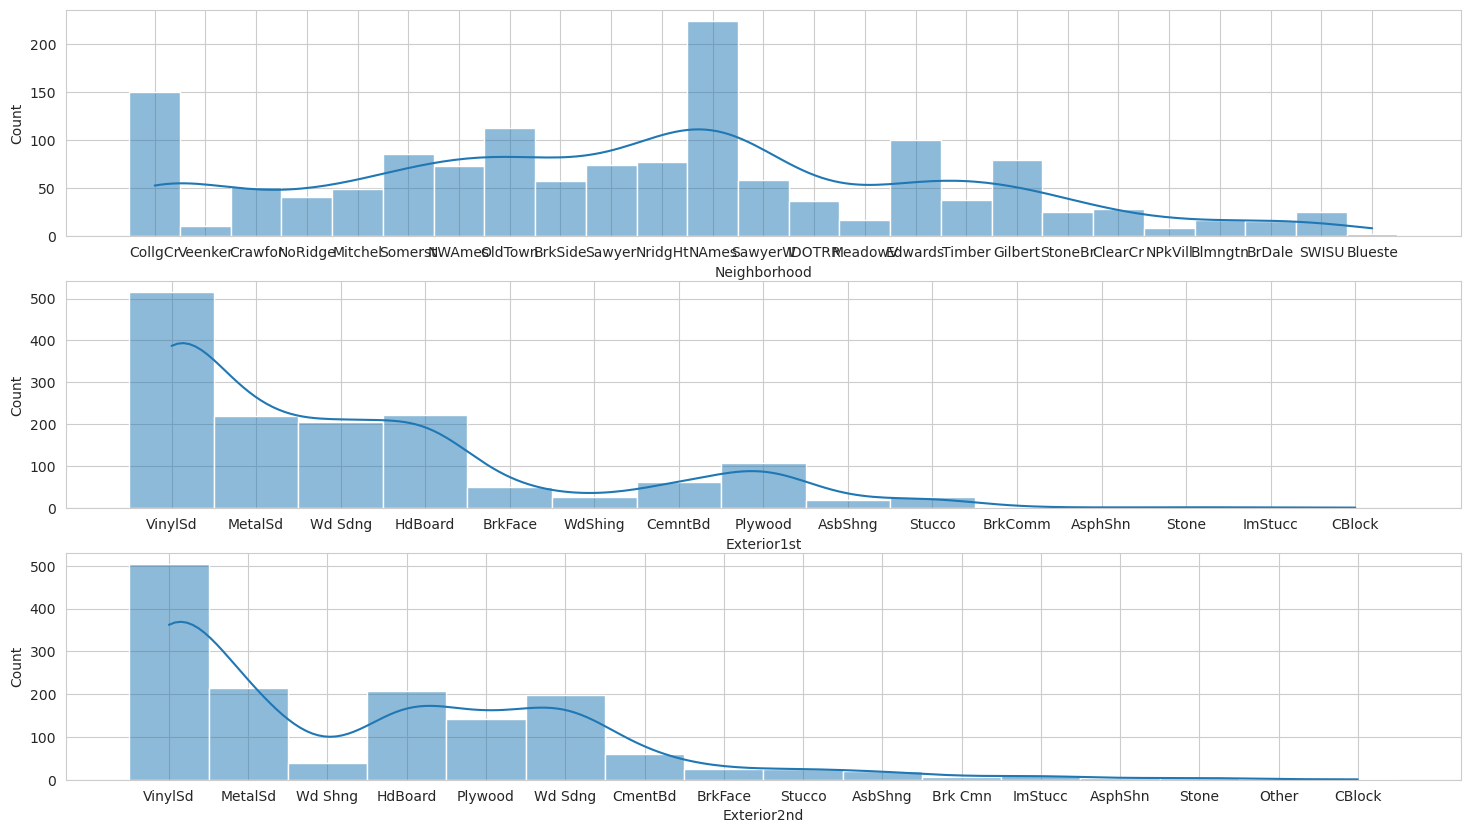

In [14]:
fig, axs = plt.subplots(ncols=1, nrows= 3, figsize=(18, 10))
axs = axs.flat
for i, col in enumerate(large_cat_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
plt.show()

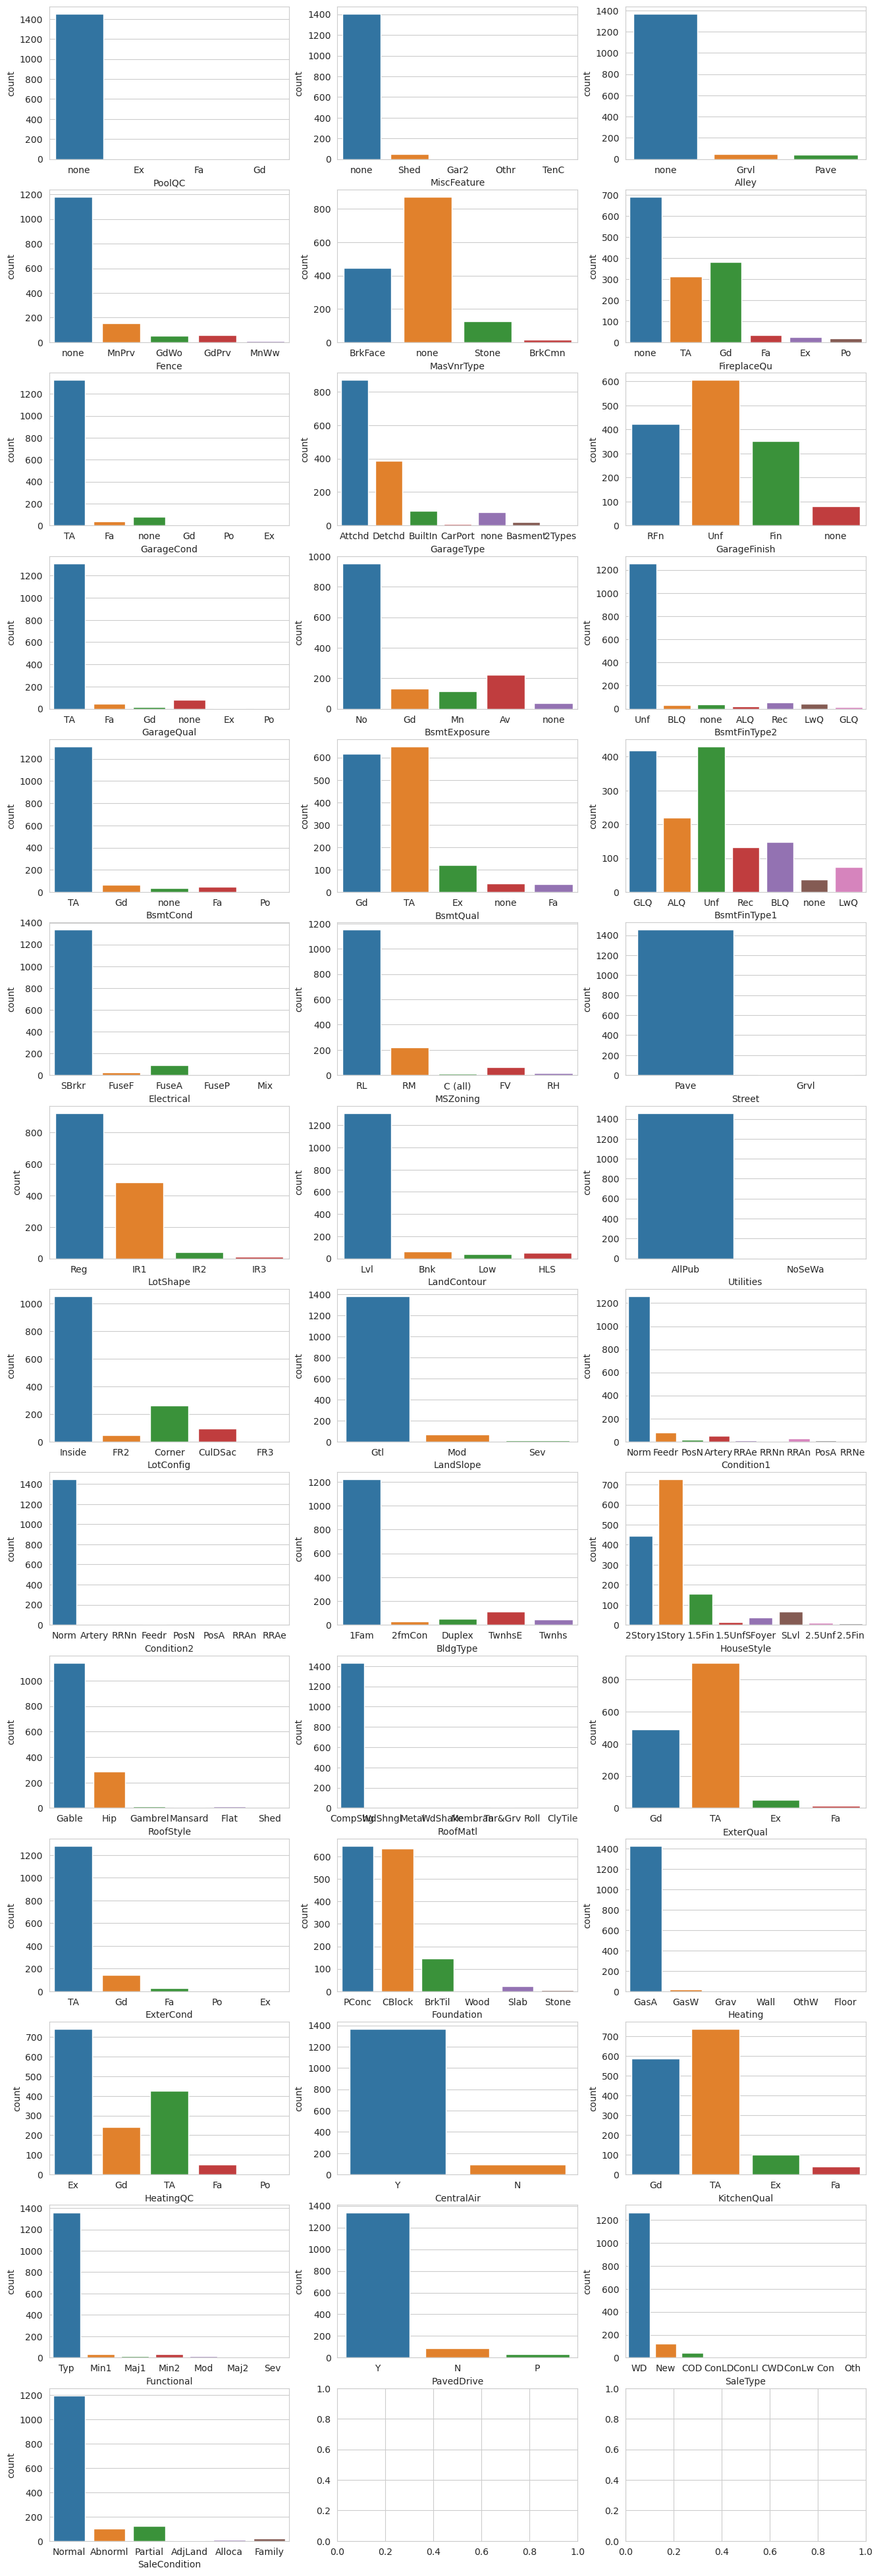

In [15]:
fig, axs = plt.subplots(ncols=3, nrows=int(np.ceil(len(small_cat_cols) / 3)), figsize=(16, 50))
axs = axs.flat
for i, col in enumerate(small_cat_cols):
    sns.countplot(data=df, x=col, ax=axs[i])
plt.show()

In [16]:
valid_dataframe = df.sample(frac=0.2, random_state=0)
train_dataframe = df.drop(valid_dataframe.index)

In [17]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("SalePrice")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
valid_ds = dataframe_to_dataset(valid_dataframe)

2024-07-01 17:52:35.222223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5679 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:0b:00.0, compute capability: 8.9


In [18]:
large_num_cols.remove("SalePrice")
large_num_cols_dict = {key: FeatureSpace.float_discretized(num_bins=10, output_mode="one_hot") for key in large_num_cols}
small_num_cols_dict = {key: FeatureSpace.integer_categorical(num_oov_indices=2, output_mode="one_hot") for key in small_num_cols}
large_cat_cols_dict = {key: FeatureSpace.string_hashed(num_bins=5, output_mode="one_hot") for key in large_cat_cols}
small_cat_cols_dict = {key: FeatureSpace.string_categorical(num_oov_indices=2, output_mode="one_hot") for key in small_cat_cols}

features = {**large_num_cols_dict, **small_num_cols_dict, **large_cat_cols_dict, **small_cat_cols_dict}

In [19]:
feature_space = FeatureSpace(features=features)

train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

2024-07-01 17:52:35.823133: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [20]:
feature_space.save("house_price_feature_space.keras")

In [21]:
preprocessed_train_ds = train_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
).shuffle(len(train_ds)).batch(32).prefetch(tf.data.AUTOTUNE)

preprocessed_valid_ds = valid_ds.map(
    lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE
).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
encoded_features = feature_space.get_encoded_features()

In [23]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=10, default=4)
    n_neurons = hp.Int("n_neurons", min_value=32, max_value=1024)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    dropout = hp.Float("dropout", min_value=0.1, max_value=0.5)
    penalty1 = hp.Float("penalty1", min_value=1e-4, max_value=0.2,
                             sampling="log")
    penalty2 = hp.Float("penalty2", min_value=1e-4, max_value=0.2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    regularizer = hp.Choice("regularizer", values=["L1", "L2", "L1L2"])
    if regularizer == "L1":
        regularizer = regularizers.L1(penalty1)
    elif regularizer == "L2":
        regularizer = regularizers.L2(penalty2)
    else:
        regularizer = regularizers.L1L2(penalty1, penalty2)

    x = layers.Dense(n_neurons, activation="relu", kernel_regularizer=regularizer)(encoded_features)
    x = layers.Dropout(dropout)(x)
    for _ in range(n_hidden - 1):
        x = layers.Dense(n_neurons, activation="relu", kernel_regularizer=regularizer)(encoded_features)
        x = layers.Dropout(dropout)(x)
    output = layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=encoded_features, outputs=output)
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mean_squared_error"])
    return model

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [25]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_loss", max_trials=30, overwrite=True,
    directory="house_prices", project_name="rnd_search_1", seed=42)
random_search_tuner.search(preprocessed_train_ds, validation_data=preprocessed_valid_ds, epochs=100, 
                           callbacks=[early_stop, lr_scheduler])

Trial 30 Complete [00h 00m 12s]
val_loss: nan

Best val_loss So Far: 1245474176.0
Total elapsed time: 00h 29m 50s


In [27]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_params = random_search_tuner.get_best_hyperparameters(num_trials=1)[0].values
best_params

{'n_hidden': 4,
 'n_neurons': 1003,
 'learning_rate': 0.0078050746283070856,
 'dropout': 0.15032799031530486,
 'penalty1': 0.11489513567351488,
 'penalty2': 0.003256201870344207,
 'optimizer': 'adam',
 'regularizer': 'L1'}

In [28]:
loss, mse = best_model.evaluate(preprocessed_valid_ds)
print(f"RMSE: {tf.math.sqrt(mse)}")

10/10 [==============================] - 1s 26ms/step - loss: 1245474176.0000 - mean_squared_error: 1245406848.0000
RMSE: 35290.3203125


In [30]:
y_pred = best_model.predict(preprocessed_valid_ds).squeeze()
labels = tf.stack([label for _, label in preprocessed_valid_ds.unbatch()], axis=0)

10/10 [==============================] - 1s 26ms/step


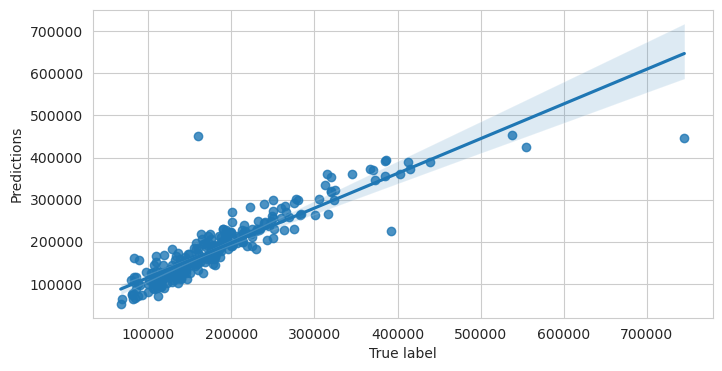

In [31]:
plt.figure(figsize=(8, 4))
ax = sns.regplot(x=labels, y=y_pred)
ax.set_ylabel("Predictions")
ax.set_xlabel("True label")
plt.show()